In [1]:
%pip install --quiet -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from models.hunt_data_loader import HuntDataLoader
from models.alzheimers_cure_2d import VAE
from models.alzheiminator_3d import ResidualUNet3D

data_loader = HuntDataLoader()

## Split Data into Training and Test

In [3]:
training_pairs, test_pairs = data_loader.split_training_test_paths(seed=69)

Display the middle slice of the first training pair

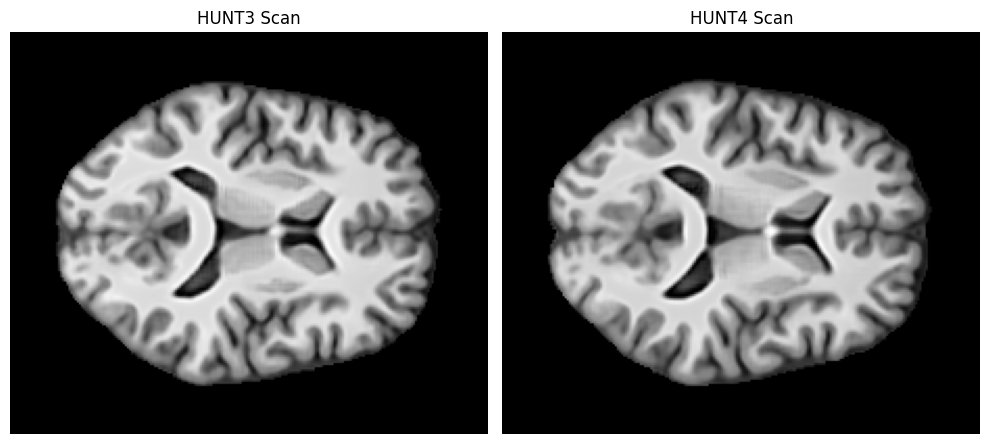

In [4]:
middle_h3 = data_loader.get_slice(training_pairs[0][0], index=90)
middle_h4 = data_loader.get_slice(training_pairs[0][1], index=90)

data_loader.display_slices(middle_h3, middle_h4)

## Train 2D-slice VAE Model

### Helper functions

In [5]:
def vae_loss(recon, target, mu, logvar):
    # Reconstruction: BCE because inputs are in [0,1]
    bce = nn.functional.binary_cross_entropy(recon, target, reduction='mean')
    # KL divergence
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    # Small KL weight for stability
    return bce + 1e-3 * kld, bce, kld


# --- Helper conversions ---
def to_torch_img(x, device):
    """
    x: numpy array or torch tensor with shape (192,224) or (1,192,224), values in [0,1]
    -> returns (1,1,192,224) float32 on device
    """
    if isinstance(x, np.ndarray):
        t = torch.from_numpy(x)
    else:
        t = x
    t = t.float()
    if t.ndim == 2:
        t = t.unsqueeze(0)  # (1,H,W)
    elif t.ndim == 3 and t.shape[0] != 1:
        # If it's (H,W,1), move channel first
        if t.shape[-1] == 1:
            t = t.permute(2,0,1)
    t = t.clamp(0, 1)
    t = t.unsqueeze(0)      # (1,1,H,W)
    return t.to(device)

def to_numpy_img(t):
    """
    t: torch tensor (1,1,H,W) or (1,H,W) or (H,W)
    -> numpy (H,W) in [0,1]
    """
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu()
    arr = t.squeeze().numpy() if isinstance(t, torch.Tensor) else np.array(t).squeeze()
    return np.clip(arr, 0.0, 1.0)

### Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = VAE(latent_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

cuda


In [7]:
print(len(training_pairs), "training pairs")

562 training pairs


In [8]:
model.train()
saved_snapshots = []  # We save snapshots every 10th pair for visualization
save_every = 10

for i in range(50):
    # Import all slices for the i'th training pair
    client = random.randint(0, len(training_pairs)-1)
    xs = data_loader.get_all_slices_as_tensor(training_pairs[client][0], crop_size=(192,224))[10:-10]  # (N, 192, 224)
    ys = data_loader.get_all_slices_as_tensor(training_pairs[client][1], crop_size=(192,224))[10:-10]  # (N, 192, 224)

    num = min(len(xs), len(ys)) # They should be equal, but just in case
    running_loss = running_bce = running_kld = 0.0

    for idx in range(num):
        x_slice = xs[idx]
        y_slice = ys[idx]

        x = to_torch_img(x_slice, device)   # (1,1,192,224)
        y = to_torch_img(y_slice, device)   # (1,1,192,224)

        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, bce, kld = vae_loss(recon, y, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item())
        running_bce  += float(bce.item())
        running_kld  += float(kld.item())

    denom = max(1, num)
    print(f"[Epoch {i}] avg total: {running_loss/denom:.4f} | "
          f"recon: {running_bce/denom:.4f} | kld: {running_kld/denom:.6f}")

    # --- Every Xth pair, save a snapshot of reconstruction vs target ---
    if (i + 1) % save_every == 0 and num > 0:
        # pick a safe index to visualize
        idx_to_show = 90 if num > 90 else (num // 2)
        with torch.no_grad():
            x_show = to_torch_img(xs[idx_to_show], device)
            y_show = to_torch_img(ys[idx_to_show], device)
            recon_show, _, _ = model(x_show)

            xy_np   = to_numpy_img(y_show)      # target (H,W) in [0,1]
            recon_np = to_numpy_img(recon_show) # recon  (H,W) in [0,1]

        saved_snapshots.append({"pair_idx": i, "xy": xy_np, "recon": recon_np})
        print(f"Saved snapshot for pair {i} at slice idx {idx_to_show}")

[Epoch 0] avg total: 0.3193 | recon: 0.3059 | kld: 13.402553
[Epoch 1] avg total: 0.2001 | recon: 0.1970 | kld: 3.061502
[Epoch 2] avg total: 0.2003 | recon: 0.1972 | kld: 3.171529
[Epoch 3] avg total: 0.1972 | recon: 0.1942 | kld: 3.006932
[Epoch 4] avg total: 0.1967 | recon: 0.1940 | kld: 2.662078
[Epoch 5] avg total: 0.1953 | recon: 0.1926 | kld: 2.702455
[Epoch 6] avg total: 0.1984 | recon: 0.1957 | kld: 2.739424
[Epoch 7] avg total: 0.1953 | recon: 0.1925 | kld: 2.807461
[Epoch 8] avg total: 0.1924 | recon: 0.1899 | kld: 2.514596
[Epoch 9] avg total: 0.1956 | recon: 0.1930 | kld: 2.600569
Saved snapshot for pair 9 at slice idx 90
[Epoch 10] avg total: 0.1949 | recon: 0.1926 | kld: 2.228404
[Epoch 11] avg total: 0.1929 | recon: 0.1902 | kld: 2.685270
[Epoch 12] avg total: 0.1946 | recon: 0.1923 | kld: 2.317326
[Epoch 13] avg total: 0.1930 | recon: 0.1909 | kld: 2.063330
[Epoch 14] avg total: 0.1916 | recon: 0.1896 | kld: 2.005955
[Epoch 15] avg total: 0.1927 | recon: 0.1906 | kld: 

### Show results of Training

Displaying snapshot from pair 9


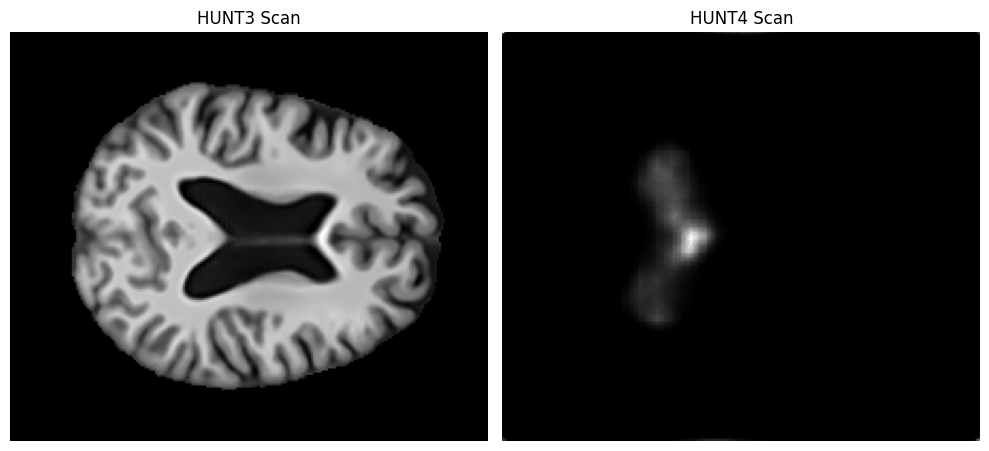

Displaying snapshot from pair 19


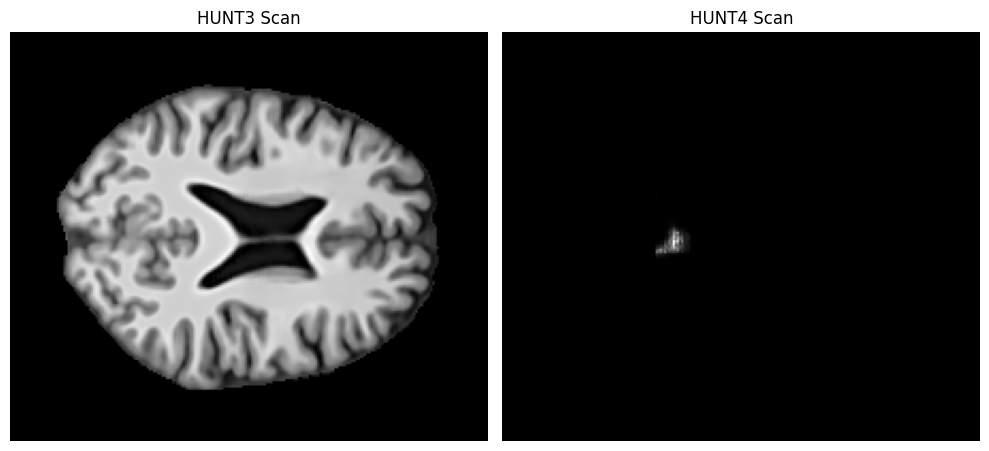

Displaying snapshot from pair 29


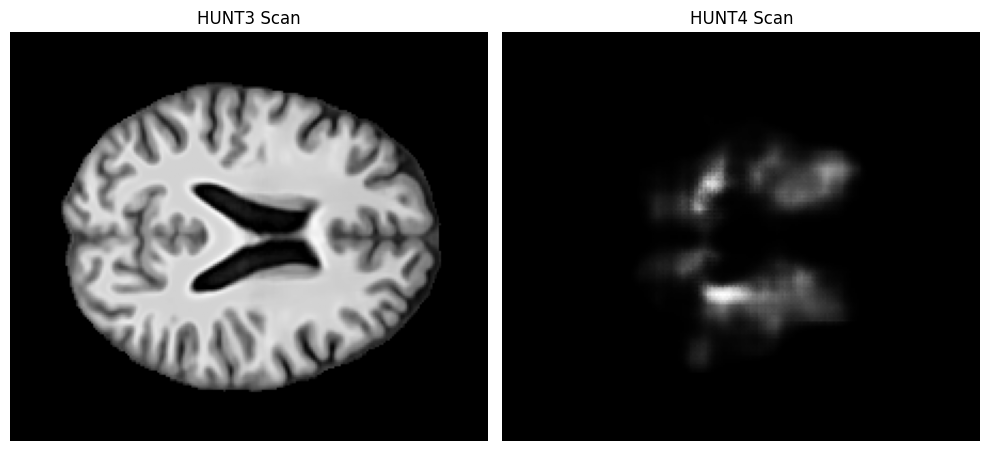

Displaying snapshot from pair 39


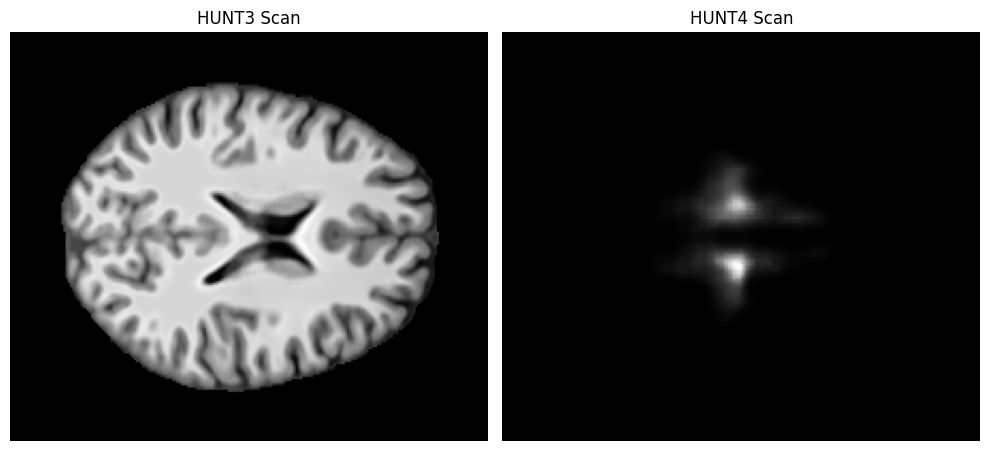

Displaying snapshot from pair 49


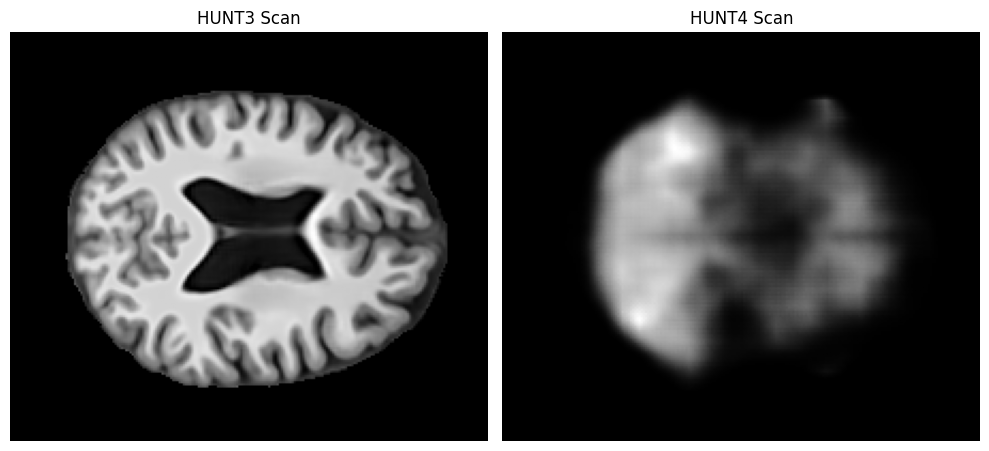

Displaying final test (pair 69, slice 90)


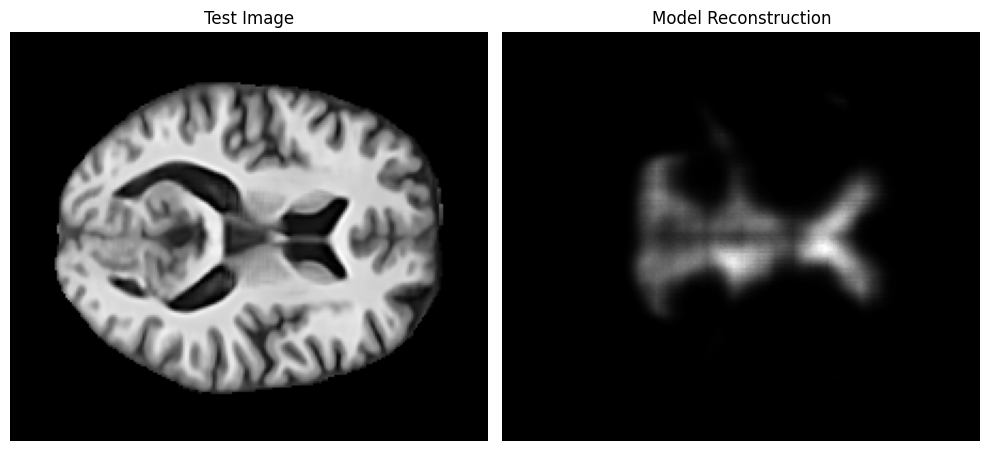

In [9]:
model.eval()
with torch.no_grad():
    xs = data_loader.get_all_slices_as_tensor(training_pairs[69][0], crop_size=(192,224))[90]
    xy = data_loader.get_all_slices_as_tensor(training_pairs[69][1], crop_size=(192,224))[90]

    x = to_torch_img(xs, device)
    recon, _, _ = model(x)

    recon_y = to_numpy_img(recon)  # (192,224)
    xy_np   = to_numpy_img(xy)     # (192,224)

# --- DISPLAY: all saved snapshots, then the final test slice ---
for snap in saved_snapshots:
    print(f"Displaying snapshot from pair {snap['pair_idx']}")
    data_loader.display_slices(snap["xy"], snap["recon"])

print("Displaying final test (pair 69, slice 90)")
data_loader.display_slices(xy_np, recon_y, "Test Image", "Model Reconstruction")

## Train 2D-slice VAE Model

### Helper functions

In [13]:
def tv_loss_3d(x):
    # x: (B,1,D,H,W)
    dz = x[:, :, 1:, :, :] - x[:, :, :-1, :, :]
    dy = x[:, :, :, 1:, :] - x[:, :, :, :-1, :]
    dx = x[:, :, :, :, 1:] - x[:, :, :, :, :-1]
    return (dz.abs().mean() + dy.abs().mean() + dx.abs().mean())

# ----------------------------
# Helpers to go (D,H,W) -> (1,1,D,H,W)
# ----------------------------
def to_torch_vol(vol, device):
    """
    Accepts:
      - list/tuple of (H,W) slices (torch or numpy)
      - a (D,H,W) torch tensor
      - a (D,H,W) numpy array
    Returns:
      (1,1,D,H,W) float32 on device
    """
    # 1) Normalize input to a torch tensor shaped (D,H,W)
    if isinstance(vol, torch.Tensor):
        t = vol.float()
    elif isinstance(vol, (list, tuple)):
        if len(vol) == 0:
            raise ValueError("Empty volume list.")
        # If list of torch.Tensors
        if isinstance(vol[0], torch.Tensor):
            t = torch.stack([v.float() for v in vol], dim=0)  # (D,H,W)
        else:
            # assume list of numpy arrays
            t = torch.from_numpy(np.stack(vol, axis=0)).float()  # (D,H,W)
    elif isinstance(vol, np.ndarray):
        t = torch.from_numpy(vol).float()
    else:
        raise TypeError(f"Unsupported vol type: {type(vol)}")

    # 2) Ensure it’s (D,H,W). If it looks like (H,W,D), permute.
    if t.dim() == 2:
        t = t.unsqueeze(0)  # (1,H,W) -> depth=1
    elif t.dim() != 3:
        raise ValueError(f"Expected 3D (D,H,W) or 2D (H,W), got shape {tuple(t.shape)}")

    D, H, W = t.shape
    # Heuristic: if the *last* dim looks like depth (many slices) and first two look like H/W (~192/224),
    # permute from (H,W,D) -> (D,H,W)
    if (D in (192,193,224) and H in (192,193,224) and W not in (192,193,224)):
        t = t.permute(2,0,1).contiguous()  # now (D,H,W)

    # 3) Add batch & channel, move to device
    return t.unsqueeze(0).unsqueeze(0).to(device)  # (1,1,D,H,W)

def mid_axial_slice(vol_1_1_dhw):
    # returns (H,W) CPU numpy for visualization
    with torch.no_grad():
        _, _, D, H, W = vol_1_1_dhw.shape
        mid = D // 2
        return vol_1_1_dhw[0, 0, mid].clamp(0, 1).detach().cpu().numpy()

### Training

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ResidualUNet3D(in_ch=1, base=32).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

print(len(training_pairs), "training pairs")

model.train()
saved_snapshots = []
save_every = 50
lambda_tv = 1e-4

cuda
562 training pairs


[Iter 0] total: 0.1894 | L1: 0.1893 | TVΔ: 0.262639
[Iter 1] total: 0.2604 | L1: 0.2604 | TVΔ: 0.211015
[Iter 2] total: 0.1415 | L1: 0.1415 | TVΔ: 0.197813
[Iter 3] total: 0.1307 | L1: 0.1307 | TVΔ: 0.179409
[Iter 4] total: 0.1122 | L1: 0.1122 | TVΔ: 0.151744
[Iter 5] total: 0.1008 | L1: 0.1008 | TVΔ: 0.147728
[Iter 6] total: 0.0796 | L1: 0.0796 | TVΔ: 0.132956
[Iter 7] total: 0.0812 | L1: 0.0812 | TVΔ: 0.126785
[Iter 8] total: 0.0674 | L1: 0.0674 | TVΔ: 0.122672
[Iter 9] total: 0.0720 | L1: 0.0720 | TVΔ: 0.108812
[Iter 10] total: 0.0649 | L1: 0.0649 | TVΔ: 0.106610
[Iter 11] total: 0.0539 | L1: 0.0539 | TVΔ: 0.093060
[Iter 12] total: 0.0498 | L1: 0.0498 | TVΔ: 0.090122
[Iter 13] total: 0.0439 | L1: 0.0439 | TVΔ: 0.085045
[Iter 14] total: 0.0419 | L1: 0.0419 | TVΔ: 0.082351
[Iter 15] total: 0.0402 | L1: 0.0402 | TVΔ: 0.077858
[Iter 16] total: 0.0387 | L1: 0.0387 | TVΔ: 0.073172
[Iter 17] total: 0.0425 | L1: 0.0425 | TVΔ: 0.070583
[Iter 18] total: 0.0384 | L1: 0.0384 | TVΔ: 0.065510
[It

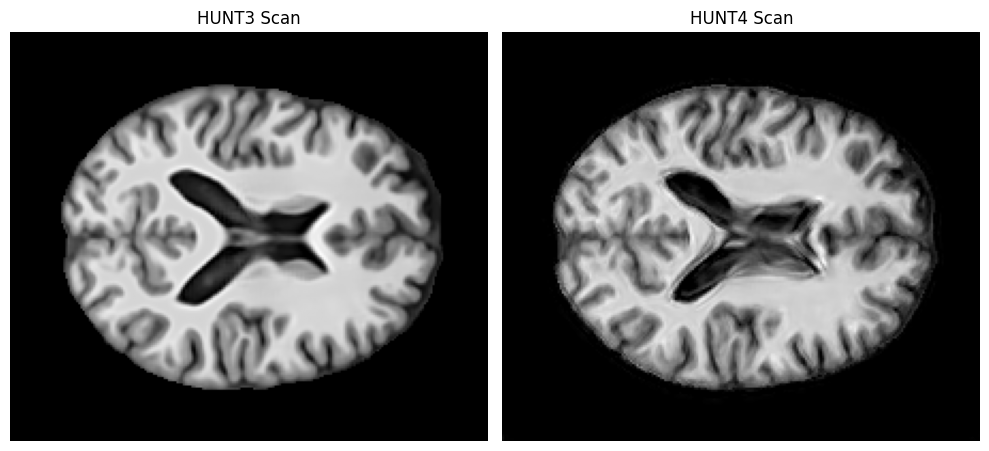

Displaying snapshot from iter 99


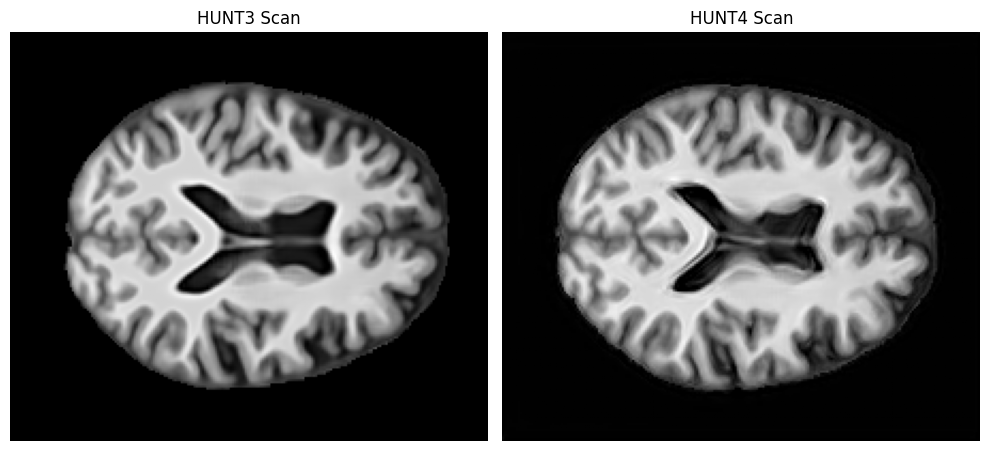

Displaying final test (pair 69, mid axial)


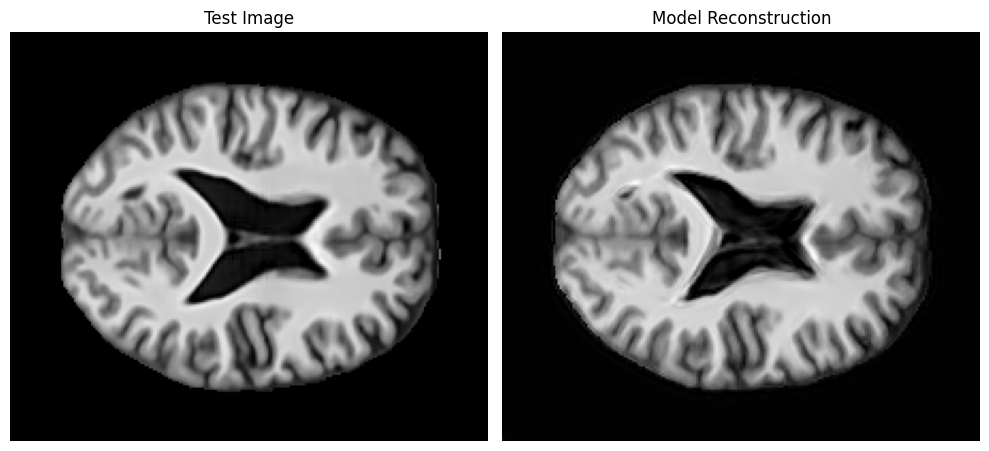

In [15]:
for i in range(100):
    # Pick a random pair and load the FULL VOLUME as stacked slices (D,H,W)
    client = random.randint(0, len(training_pairs) - 1)
    # keep your existing loader; use all slices as a volume (optionally trim edges as you did)
    xs = data_loader.get_all_slices_as_tensor(training_pairs[client][0], crop_size=(192, 224))  # (D,H,W)
    ys = data_loader.get_all_slices_as_tensor(training_pairs[client][1], crop_size=(192, 224))  # (D,H,W)

    # If you previously removed 10 slices at each end, you can keep that; otherwise use full stack.
    # xs, ys = xs[10:-10], ys[10:-10]

    # Convert to (1,1,D,H,W)
    x = to_torch_vol(xs, device)
    y = to_torch_vol(ys, device)

    optimizer.zero_grad()
    y_hat, delta = model(x)

    # L1 + small TV on residual (stable & simple)
    l1 = F.l1_loss(y_hat, y)
    tv = tv_loss_3d(delta)
    loss = l1 + lambda_tv * tv

    loss.backward()
    optimizer.step()

    print(f"[Iter {i}] total: {loss.item():.4f} | L1: {l1.item():.4f} | TVΔ: {tv.item():.6f}")

    # --- Save a snapshot every X iters (mid axial slice) ---
    if (i + 1) % save_every == 0:
        with torch.no_grad():
            target_mid = mid_axial_slice(y)
            recon_mid  = mid_axial_slice(y_hat)
        saved_snapshots.append({"pair_idx": i, "xy": target_mid, "recon": recon_mid})
        print(f"Saved snapshot for iter {i} (mid-axial slice)")

# ----------------------------
# Eval on a fixed pair (e.g., 69) and display
# ----------------------------
model.eval()
with torch.no_grad():
    xs = data_loader.get_all_slices_as_tensor(training_pairs[69][0], crop_size=(192, 224))
    xy = data_loader.get_all_slices_as_tensor(training_pairs[69][1], crop_size=(192, 224))

    x = to_torch_vol(xs, device)
    y_hat, _ = model(x)

    xy_np   = mid_axial_slice(to_torch_vol(xy, device))
    recon_y = mid_axial_slice(y_hat)

Displaying snapshot from iter 49


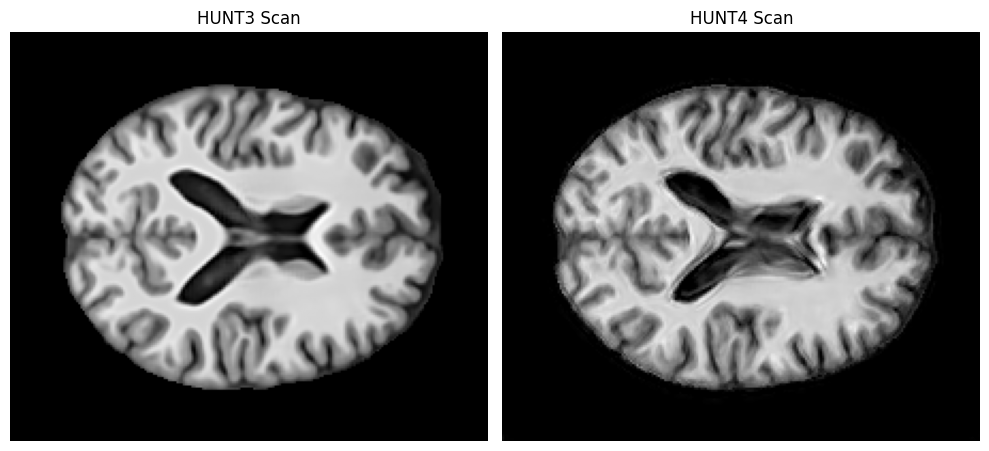

Displaying snapshot from iter 99


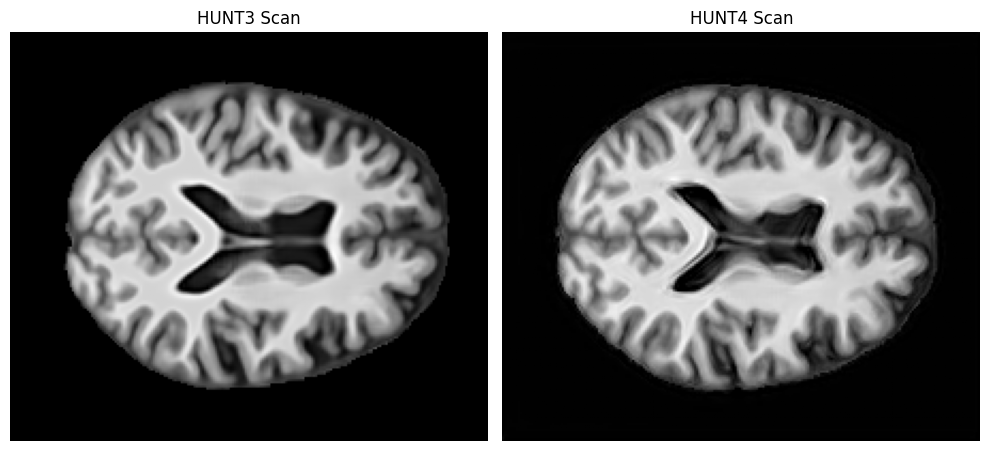

Displaying final test (pair 69, mid axial)


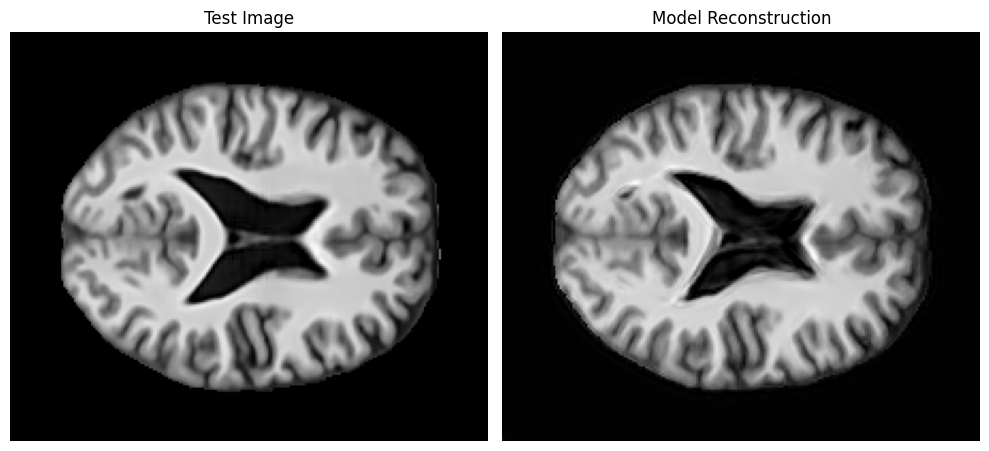

In [16]:
# --- DISPLAY: all saved snapshots, then the final test mid-slice ---
for snap in saved_snapshots:
    print(f"Displaying snapshot from iter {snap['pair_idx']}")
    data_loader.display_slices(snap["xy"], snap["recon"])

print("Displaying final test (pair 69, mid axial)")
data_loader.display_slices(xy_np, recon_y, "Test Image", "Model Reconstruction")